In [43]:
import glob
import pandas as pd
import requests
from graphdbfunctions import *
from great_tables import GT
import polars as pl
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
GRAPHDB_HOST = "http://localhost:7200"
GRAPHDB_REPO = 'lhay' # Your repository ID/Name
proxies = {
 "http": None,
 "https": None,
}

### 1. Get triplets

In [35]:
query = """
PREFIX cad_ltype: <http://rdf.geohistoricaldata.org/id/codes/cadastre/landmarkType/>
PREFIX addr: <http://rdf.geohistoricaldata.org/def/address#>
PREFIX cad: <http://rdf.geohistoricaldata.org/def/cadastre#>
select ?s ?nature_pred ?nature_gold where {
    ?s a addr:Landmark;
    addr:isLandmarkType cad_ltype:Plot.
    GRAPH <http://rdf.geohistoricaldata.org/auto> {
    ?s addr:hasAttribute/addr:hasAttributeVersion/cad:hasPlotNature ?nature_pred.
    }
    GRAPH <http://rdf.geohistoricaldata.org/gold> {
    ?s addr:hasAttribute/addr:hasAttributeVersion/cad:hasPlotNature ?nature_gold.
    }
} 
"""

We first retrieve the simple triples (property path of length = 1) in both graphs (gold standard and automatically build).

In [36]:
response = select_sparql_query(GRAPHDB_HOST,GRAPHDB_REPO,query,proxies)
natures_df = convert_response_to_df(response)

In [37]:
#Replace substribnn in each column
natures_df['nature_pred'] = natures_df['nature_pred'].str.replace('http://rdf.geohistoricaldata.org/id/codes/cadastre/plotNature/','')
natures_df['nature_gold'] = natures_df['nature_gold'].str.replace('http://rdf.geohistoricaldata.org/id/codes/cadastre/plotNature/','')

In [38]:
# If nature pred equal to "big" or to "T p390, replace by NIL
natures_df['nature_pred'] = natures_df['nature_pred'].replace(['big','T p390'], 'NIL')

In [39]:
#Compute a confusion matrix
confusion_matrix = pd.crosstab(natures_df['nature_gold'], natures_df['nature_pred'], rownames=['gold'], colnames=['pred'], margins=True)

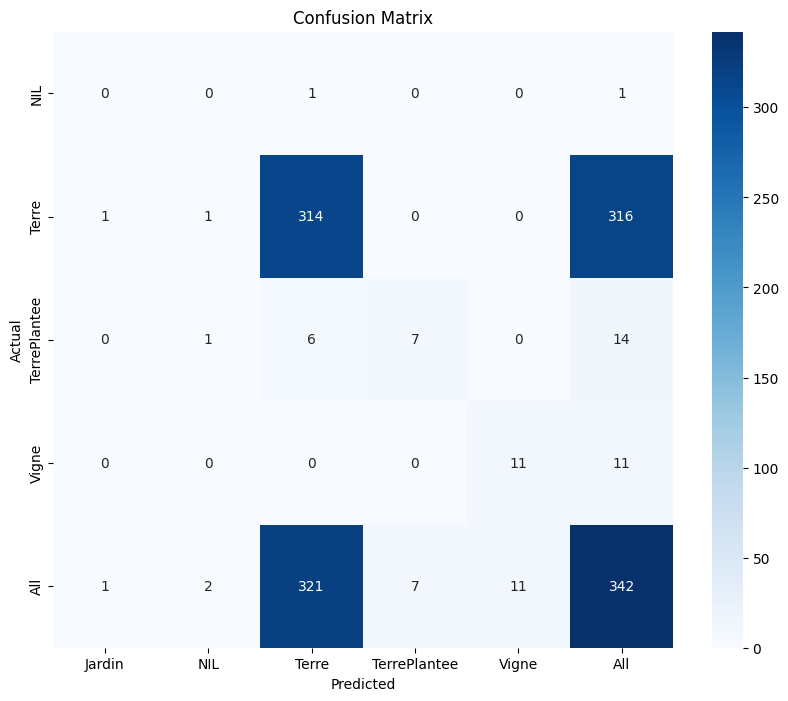

In [9]:
#Color the confusion matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [50]:
target = ["Terre","TerrePlantee","Vigne","Jardin","NIL"]
report = classification_report(natures_df['nature_pred'], natures_df['nature_gold'])
print(report)

              precision    recall  f1-score   support

      Jardin       0.00      0.00      0.00         1
         NIL       0.00      0.00      0.00         2
       Terre       0.99      0.98      0.99       321
TerrePlantee       0.50      1.00      0.67         7
       Vigne       1.00      1.00      1.00        11

    accuracy                           0.97       342
   macro avg       0.50      0.60      0.53       342
weighted avg       0.98      0.97      0.97       342



e:\codes\cadastre_annotation_semantique\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\codes\cadastre_annotation_semantique\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\codes\cadastre_annotation_semantique\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [10]:
#Convert to latex
latex_table = confusion_matrix.to_latex()
latex_table = latex_table.replace('gold', 'Gold standard nature')
latex_table = latex_table.replace('pred', 'Preditected nature')
#Reorder to have NIL column before last